# EXPENSES CLASSIFICATION

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string
import re
import unicodedata




/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


#### Let's define some functions.....

In [2]:
def split_transactions_on_duplicated(transactions_df): 
    ''' Get duplicated and not duplicated transactions based on same descriptions but differenrent mcc or mcg names'''
    # Keep unique values based on both description and  other column
    unique_transactions_df = transactions_df.drop_duplicates().reset_index(drop=True)
    # Get from the entire unique (both description and other included columns) 
    # the positions of duplicated based on description
    duplicated_descriptions_positions = unique_transactions_df.duplicated(keep=False, subset ="description")
    # So these will contain the same descriptions that have differnet mcc or mcg names
    # Keep the non duplicated 
    non_duplicated = unique_transactions_df[~duplicated_descriptions_positions]
    non_duplicated = non_duplicated.reset_index(drop=True)
    # Keep the duplicated
    duplicated = unique_transactions_df[duplicated_descriptions_positions]
    duplicated = duplicated.reset_index(drop=True)

    return duplicated, non_duplicated

#### For each one description in unique descriptions dataframe check selected_transactions_df mcg and change if needed

In [3]:
def adjust_mcc_values(transactions_df):
    ''' 
    Creates a new dataframe where the same descriptions have the same MCC names.
    If more than 1 mcc names exist for a unique description, the most frequent is being choosed.
    In this choice, "Computer Program/Sys Design" and "Electrical Contractors" is excluded as most of transactions have almost
    always this category in combination with some other categories.
    '''
    duplicated_df, non_duplicated_df = split_transactions_on_duplicated(transactions_df)
    multiple_mcc_df = pd.DataFrame()
    for i, row in duplicated_df.iterrows():
        temp_transactions_df = duplicated_df.loc[duplicated_df["description"] == row["description"]]
        temp_unique_df = temp_transactions_df.drop_duplicates()
        temp_unique_df = temp_unique_df.reset_index(drop=True)

        # If unique couples of description-mcc more than 1
        if len(temp_unique_df)>1:
            multiple_mcc_df = multiple_mcc_df.append(temp_unique_df, ignore_index=True)
            mcc_freq_df = temp_unique_df.groupby(temp_unique_df.MCC_Name.tolist(),as_index=False).size()
            # Find which mcc has the greatest frequency in order to use that for all same descriptions
            # we drop and not count Computer Program/Sys Design because has beedn found in many tests as a false
            # classification when more than 1 classes exist. It needs more testing
            max_freq_df = mcc_freq_df.loc[mcc_freq_df["size"]==mcc_freq_df["size"].max()]
            max_freq_df = max_freq_df.reset_index(drop=True)
            max_freq_df.columns = ["MCC_Name", "freq"]

            # Check if "Electrical Contractors" exists in rows in order to drop it and choose another one
            if max_freq_df["MCC_Name"].isin(["Electrical Contractors"]).any():
                max_freq_df = max_freq_df.loc[max_freq_df["MCC_Name"] != "Electrical Contractors"]
                max_freq_df = max_freq_df.reset_index(drop=True)
            else:
                # Check if "Computer Program/Sys Design" exists in rows in order to drop it and choose another one
                max_freq_df = max_freq_df.loc[max_freq_df["MCC_Name"] != "Computer Program/Sys Design"]
                max_freq_df = max_freq_df.reset_index(drop=True)

            main_mcc_name = max_freq_df["MCC_Name"][0]
            # Change the value in selected rows in column MCC_Name with the found mcc max value
            duplicated_df.loc[(duplicated_df["description"] == row["description"]),'MCC_Name']=main_mcc_name
    cleaned_duplicated_df = duplicated_df.drop_duplicates().reset_index(drop=True)
    
    return non_duplicated_df.append(cleaned_duplicated_df, ignore_index= True), multiple_mcc_df         


In [16]:
def remove_words(descriptions, words_df):
    ''' 
    This function gets a transactions df and a dataframe of words. It excludes the words from words df from each sentence as defined
    from names of selected columns
    '''
    replace_words = re.compile(r'\b(' + ('|'.join(words_df["word"])) + r')\b')
    descriptions = descriptions.str.replace(replace_words, '')

    return descriptions

In [17]:
def remove_accent_and_uppercase(description: str) -> str:
    normalized_description = unicodedata.normalize("NFD", description)
    cleaned_description = re.sub("[\u0300-\u036f]", "", normalized_description).upper()

    return cleaned_description

### Import data from csv files

In [6]:
full_category_transactions_df = pd.read_csv('../data/01_raw/bank/basic_processed_transactions.csv')

In [12]:
full_category_transactions_df

description                    MCC_Name  \
0              CHALVATZIS PANAGIO         Veterinary Services   
1              CHALVATZIS PANAGIO         Veterinary Services   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
...                           ...                         ...   
1364113          MUSEE ST RAYMOND  Intra-government Purchases   
1364114          MONTEESCATHEDREC  Intra-government Purchases   
1364115           HORODATEUR NICE  Intra-government Purchases   
1364116    COMMUNE DE SAINT TROPE  Intra-government Purchases   
1364117          COMMUNE DE PARIS  Intra-government Purchases   

                                 MCG_Name         Wysely_Name  
0        Business & Professional Services  medical/healthcare  
1        Business & Professional Services  medical/healthcare  
2        Business & Professional Services  medical/healthcare  
3        Business & Professional Services  medical/healthcare  
4        Business & Professional Services  medical/healthcare  
...                                   ...                 ...  
1364113  Organisations & Statutory Bodies  fees/charges/taxes  
1364114  Organisations & Statutory Bodies  fees/charges/taxes  
1364115  Organisations & Statutory Bodies  fees/charges/taxes  
1364116  Organisations & Statutory Bodies  fees/charges/taxes  
1364117  Organisations & Statutory Bodies  fees/charges/taxes  

[1364118 rows x 4 columns]

#### As we see we need some cleaning in descriptions. We have mainly to remove punctation, remove numbers (check cleaning functions for more). After these, we have to remove the single letters that will be left alone :) ..... So let's define the basic cleaning functions tha will be used below....

In [36]:
def connect_single_letters(text):
    ''' Example: "D E Y A  SITEIAS" is converted to "DEYA  SITEIAS" '''
    pattern = re.compile(r'\b([a-z]) (?=[a-z]\b)', re.I)

    return  re.sub(pattern, r'\g<1>', text)

def clean_website_name(text:str):
    ''' Example: "www.eshop.gr" is converted to "eshop" '''
    list_of_words = []
    if text is not np.nan:
        for word in text.split():
            word = word.replace("www.", "")
            word = word.replace("WWW.", "")
            word = word.replace("WWW", "")
            word = word.replace("www", "")
            word = word.replace(".gr", "")
            word = word.replace(".GR", "")
            word = word.replace(".com", "")
            word = word.replace(".COM", "")
            list_of_words.append(word)
        words=' '.join(list_of_words)
    else:
        words=""

    return words

def remove_punctuation(text):
    ''' Removes punctations from descriptions '''
    word_list = []
    for words in text:
        characters_list = []
        for characters in words:
            if characters not in string.punctuation:
                characters_list.append(characters)
            else:
                characters_list.append(" ")
        word=''.join(characters_list)
        word_list.append(word)
    words=''.join(word_list)

    return words

def remove_numbers(text):
    ''' Example: "FYSIKO AERIO VW507" is converted to "FYSIKO AERIO VW" '''
    pattern = r'[0-9]'
    # Match all digits in the string and replace them by empty string
    modified_text = re.sub(pattern, '', text)

    return modified_text

def remove_single_letters(text):
    ''' Removes the single letters included in descriptions '''
    no_letter=[word for word in text.split() if len(word)>1]
    words_no_letter=' '.join(no_letter)

    return words_no_letter

def clean_descriptions(transactions_df):
    ''' Combines all the basic cleaning functions '''
    transactions_df['new_description']=transactions_df['description'].apply(lambda x: clean_website_name(x))
    transactions_df['new_description']=transactions_df['new_description'].apply(lambda x: remove_punctuation(x))
    transactions_df['new_description']=transactions_df['new_description'].apply(lambda x: connect_single_letters(x))
    transactions_df['new_description']=transactions_df['new_description'].apply(lambda x: remove_numbers(x))
    transactions_df['new_description']=transactions_df['new_description'].apply(lambda x: remove_single_letters(x))

    return transactions_df

def clean_based_on_bow(transactions_df, bow_to_remove):
    ''' It creates a new transactions_df with a new column of removed names & surnames from description'''
    # Create through re function the pattern of the words from dataframe
    replace_words = re.compile(r'\b(' + ('|'.join(bow_to_remove["words"])) + r')\b')
    # Update new_description column with the removed names from descriptions
    transactions_df["new_description"] = transactions_df["new_description"].str.replace(replace_words, '')

    return transactions_df

# not used
def _clean_based_on_bow(text, bow_to_remove):
    '''Clean based on BOW file" '''
    list_of_words = []
    if text is not np.nan:
        for word in text.split():
            found_word = False
            for i, row in bow_to_remove.iterrows():
                if word == row["words"]:
                    found_word = True
                    break
            if not found_word:
                list_of_words.append(word)
        words=' '.join(list_of_words)
    else:
        words=""
    
    return words



### Let's read names and surnames, beacuse we want to include them also in the training session as other

In [7]:
final_surnames_df = pd.read_csv('../data/01_raw/bank/final_surnames.csv')
final_names_df = pd.read_csv('../data/01_raw/bank/final_names.csv')

#### Clean the descriptions with the defined basic cleaning function!

In [9]:
cleaned_transactions_df = clean_descriptions(full_category_transactions_df)

#### We have the cleaned descriptions in a new column named "new_description"

In [14]:
cleaned_transactions_df

description                    MCC_Name  \
0              CHALVATZIS PANAGIO         Veterinary Services   
1              CHALVATZIS PANAGIO         Veterinary Services   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET         Veterinary Services   
...                           ...                         ...   
1364113          MUSEE ST RAYMOND  Intra-government Purchases   
1364114          MONTEESCATHEDREC  Intra-government Purchases   
1364115           HORODATEUR NICE  Intra-government Purchases   
1364116    COMMUNE DE SAINT TROPE  Intra-government Purchases   
1364117          COMMUNE DE PARIS  Intra-government Purchases   

                                 MCG_Name         Wysely_Name  \
0        Business & Professional Services  medical/healthcare   
1        Business & Professional Services  medical/healthcare   
2        Business & Professional Services  medical/healthcare   
3        Business & Professional Services  medical/healthcare   
4        Business & Professional Services  medical/healthcare   
...                                   ...                 ...   
1364113  Organisations & Statutory Bodies  fees/charges/taxes   
1364114  Organisations & Statutory Bodies  fees/charges/taxes   
1364115  Organisations & Statutory Bodies  fees/charges/taxes   
1364116  Organisations & Statutory Bodies  fees/charges/taxes   
1364117  Organisations & Statutory Bodies  fees/charges/taxes   

                  new_description  
0              CHALVATZIS PANAGIO  
1              CHALVATZIS PANAGIO  
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  
...                           ...  
1364113          MUSEE ST RAYMOND  
1364114          MONTEESCATHEDREC  
1364115           HORODATEUR NICE  
1364116    COMMUNE DE SAINT TROPE  
1364117          COMMUNE DE PARIS  

[1364118 rows x 5 columns]

#### Keep columns.....

In [10]:
final_transactions_df = cleaned_transactions_df[["description","new_description", "Wysely_Name"]]


In [21]:
final_transactions_df

description           new_description  \
0              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
1              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
...                           ...                       ...   
1364113          MUSEE ST RAYMOND          MUSEE ST RAYMOND   
1364114          MONTEESCATHEDREC          MONTEESCATHEDREC   
1364115           HORODATEUR NICE           HORODATEUR NICE   
1364116    COMMUNE DE SAINT TROPE    COMMUNE DE SAINT TROPE   
1364117          COMMUNE DE PARIS          COMMUNE DE PARIS   

                Wysely_Name  
0        medical/healthcare  
1        medical/healthcare  
2        medical/healthcare  
3        medical/healthcare  
4        medical/healthcare  
...                     ...  
1364113  fees/charges/taxes  
1364114  fees/charges/taxes  
1364115  fees/charges/taxes  
1364116  fees/charges/taxes  
1364117  fees/charges/taxes  

[1364118 rows x 3 columns]

#### Need to drop the left empty description rows

In [11]:
final_transactions_df = final_transactions_df.loc[final_transactions_df["new_description"] != ""]
final_transactions_df = final_transactions_df.reset_index(drop=True)
final_transactions_df


description           new_description  \
0              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
1              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
...                           ...                       ...   
1363028          MUSEE ST RAYMOND          MUSEE ST RAYMOND   
1363029          MONTEESCATHEDREC          MONTEESCATHEDREC   
1363030           HORODATEUR NICE           HORODATEUR NICE   
1363031    COMMUNE DE SAINT TROPE    COMMUNE DE SAINT TROPE   
1363032          COMMUNE DE PARIS          COMMUNE DE PARIS   

                Wysely_Name  
0        medical/healthcare  
1        medical/healthcare  
2        medical/healthcare  
3        medical/healthcare  
4        medical/healthcare  
...                     ...  
1363028  fees/charges/taxes  
1363029  fees/charges/taxes  
1363030  fees/charges/taxes  
1363031  fees/charges/taxes  
1363032  fees/charges/taxes  

[1363033 rows x 3 columns]

#### Check the labels percentage before the training....

In [23]:
final_transactions_df.groupby(["Wysely_Name"]).agg("count")

description  new_description
Wysely_Name                                              
charity and donation                3282             3282
child and school                    2372             2372
clothing                          135517           135517
eating out and take aways         169097           169097
education                          20225            20225
fashion and beauty                 49919            49919
fees/charges/taxes                 19950            19950
fun and leisure                   119744           119744
gambling                            4578             4578
household items/supplies          439132           439132
housing                            27804            27804
insurance and pension               9337             9337
medical/healthcare                 96422            96422
office/electronics/software        26432            26432
other essential                     9515             9515
other lifestyle                    17556            17556
savings/investments                 6398             6398
telecommunications                 39272            39272
transport and fuel                144100           144100
utilities                          22381            22381

#### Select again columns and rename them

In [24]:
final_transactions_df

description           new_description  \
0              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
1              CHALVATZIS PANAGIO        CHALVATZIS PANAGIO   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET   
...                           ...                       ...   
1363028          MUSEE ST RAYMOND          MUSEE ST RAYMOND   
1363029          MONTEESCATHEDREC          MONTEESCATHEDREC   
1363030           HORODATEUR NICE           HORODATEUR NICE   
1363031    COMMUNE DE SAINT TROPE    COMMUNE DE SAINT TROPE   
1363032          COMMUNE DE PARIS          COMMUNE DE PARIS   

                Wysely_Name  
0        medical/healthcare  
1        medical/healthcare  
2        medical/healthcare  
3        medical/healthcare  
4        medical/healthcare  
...                     ...  
1363028  fees/charges/taxes  
1363029  fees/charges/taxes  
1363030  fees/charges/taxes  
1363031  fees/charges/taxes  
1363032  fees/charges/taxes  

[1363033 rows x 3 columns]

In [12]:
final_transactions_df = final_transactions_df[["new_description", "Wysely_Name"]]
final_transactions_df.columns = ["description", "classification"]


In [26]:
final_transactions_df

description      classification
0              CHALVATZIS PANAGIO  medical/healthcare
1              CHALVATZIS PANAGIO  medical/healthcare
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
...                           ...                 ...
1363028          MUSEE ST RAYMOND  fees/charges/taxes
1363029          MONTEESCATHEDREC  fees/charges/taxes
1363030           HORODATEUR NICE  fees/charges/taxes
1363031    COMMUNE DE SAINT TROPE  fees/charges/taxes
1363032          COMMUNE DE PARIS  fees/charges/taxes

[1363033 rows x 2 columns]

In [13]:
final_transactions_df.to_csv(r'final_transactions.csv', index = False)

In [6]:
final_transactions_df = pd.read_csv('../data/01_raw/bank/final_transactions.csv')

In [7]:
final_transactions_df

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


description      classification
0              CHALVATZIS PANAGIO  medical/healthcare
1              CHALVATZIS PANAGIO  medical/healthcare
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
...                           ...                 ...
1363028          MUSEE ST RAYMOND  fees/charges/taxes
1363029          MONTEESCATHEDREC  fees/charges/taxes
1363030           HORODATEUR NICE  fees/charges/taxes
1363031    COMMUNE DE SAINT TROPE  fees/charges/taxes
1363032          COMMUNE DE PARIS  fees/charges/taxes

[1363033 rows x 2 columns]

### Need to also add  names-surnames as transaction descriptions in other category

In [11]:
names_df = pd.read_csv('../data/01_raw/bank/greek_names.csv')
surnames_df = pd.read_csv('../data/01_raw/bank/greek_surnames.csv')

In [11]:
#final_names_df = pd.read_csv('../data/01_raw/bank/final_names.csv')
#final_surnames_df = pd.read_csv('../data/01_raw/bank/final_surnames.csv')


In [13]:
final_names_df = names_df
final_surnames_df = surnames_df

In [14]:
final_names_df["classification"]= "other"
final_names_df.columns=["description", "classification"]

In [15]:
final_surnames_df["classification"]= "other"
final_surnames_df.columns=["description", "classification"]

In [16]:
train_transactions_df = final_transactions_df.append(final_names_df, ignore_index=True)
train_transactions_df = train_transactions_df.append(final_surnames_df, ignore_index=True)

In [17]:
train_transactions_df

description      classification
0              CHALVATZIS PANAGIO  medical/healthcare
1              CHALVATZIS PANAGIO  medical/healthcare
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
...                           ...                 ...
1637460                     ΩΣΤΙΝ               other
1637461                        ΩΤ               other
1637462                      ΩΤΤΑ               other
1637463                     ΩΤΤΑΣ               other
1637464                     ΩΦΦΡΕ               other

[1637465 rows x 2 columns]

#### Save it as csv "training"

In [18]:
#train_transactions_df.to_csv(r'train_transactions_df.csv', index = False)


In [9]:
train_transactions_df = pd.read_csv('../data/01_raw/bank/train_transactions_df.csv')


### Keep only unique to make proccessing faster

#### Save it in order to check it in another iteration and maybe manually adjust some categories

In [47]:
unique_train_transactions_df = train_transactions_df.drop_duplicates(subset="description").reset_index(drop=True)
#unique_train_transactions_df.to_csv(r'unique_train_transactions.csv', index = False)
unique_train_transactions_df

description      classification
0                         CHALVATZIS PANAGIO  medical/healthcare
1                   ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
2                           KARAGEORGIOU MAR  medical/healthcare
3                ΔΙΑΜΑΝΤΗΣ ΦΙΛΙΜΩΝ ΣΑΛΒΑΤΟΡΕ  medical/healthcare
4       ΠΕΡΑΚΗ ΚΑΤΙΡΤΖΟΓΛΟΥ ΓΟΕ ΖΩΩΝ ΜΕΡΙΜΝΑ  medical/healthcare
...                                      ...                 ...
612960                              FERETZIS               other
612961                           FERETZOGLOU               other
612962                                FERETI               other
612963                                FERTET               other
612964                               FERTINI               other

[612965 rows x 2 columns]

In [10]:
import dask.dataframe as dd
import multiprocessing

#### Greek to english

In [11]:
from greeklish.converter import Converter

def greek_to_english(description):
    ''' 
    This function converts a greek description (every word) to english (greeklish). The possible greek to english combinations 
    for each word are more than 1.
    We choose to first one as calculated by the library.
    '''
    if description == "":
        return " "
    converter = Converter(max_expansions=1)

    return converter.convert(u''+description)[0].lower()

In [21]:
unique_train_transactions_df = train_transactions_df.drop_duplicates(subset="description").reset_index(drop=True)
unique_train_transactions_df = unique_train_transactions_df[["description"]]

unique_train_transactions_df["new_description"] = dd.from_pandas(unique_train_transactions_df.description, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: greek_to_english(row))).compute(scheduler='processes')

#### Merge it back with the entire dataframe

In [22]:
train_transactions_df = pd.merge(train_transactions_df, unique_train_transactions_df, on=['description','description'])
train_transactions_df

description      classification  \
0              CHALVATZIS PANAGIO  medical/healthcare   
1              CHALVATZIS PANAGIO  medical/healthcare   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
...                           ...                 ...   
1637460                     ΩΣΤΙΝ               other   
1637461                        ΩΤ               other   
1637462                      ΩΤΤΑ               other   
1637463                     ΩΤΤΑΣ               other   
1637464                     ΩΦΦΡΕ               other   

                  new_description  
0              chalvatzis panagio  
1              chalvatzis panagio  
2        parasxhs spyridwn my vet  
3        parasxhs spyridwn my vet  
4        parasxhs spyridwn my vet  
...                           ...  
1637460                     wstin  
1637461                        wt  
1637462                      wtta  
1637463                     wttas  
1637464                     wffre  

[1637465 rows x 3 columns]

In [23]:
train_transactions_df = train_transactions_df[["new_description", "classification"]]
train_transactions_df.columns = ["description", "classification"]

In [24]:
train_transactions_df

description      classification
0              chalvatzis panagio  medical/healthcare
1              chalvatzis panagio  medical/healthcare
2        parasxhs spyridwn my vet  medical/healthcare
3        parasxhs spyridwn my vet  medical/healthcare
4        parasxhs spyridwn my vet  medical/healthcare
...                           ...                 ...
1637460                     wstin               other
1637461                        wt               other
1637462                      wtta               other
1637463                     wttas               other
1637464                     wffre               other

[1637465 rows x 2 columns]

#### English steming

#### We have choosen to have first Greek to Enlish and then stem. Of course, the greek words do not have the correct stemming since they are in english format.
#### After experiments, we calculated to this approach. Of course and we lose some of the right stemming of greek words, but since the greeklish words are way
#### more than the greek words in the raw dataset, we followed this method.

In [22]:
# English stem
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def english_stemmer(description):
    ''' This function gets a description and returns the stemming of it (for each word of the description)'''
    stemmer = PorterStemmer()
    words = word_tokenize(description)
    list_of_words = []
    for w in words:
        transformed_word = stemmer.stem(w)
        transformed_word = transformed_word.lower()
        list_of_words.append(transformed_word)
    words=' '.join(list_of_words)

    return words



In [23]:
unique_train_transactions_df = train_transactions_df.drop_duplicates(subset="description").reset_index(drop=True)
unique_train_transactions_df = unique_train_transactions_df[["description"]]

unique_train_transactions_df["new_description"] = dd.from_pandas(unique_train_transactions_df.description, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: english_stemmer(row))).compute(scheduler='processes')

In [24]:
train_transactions_df = pd.merge(train_transactions_df, unique_train_transactions_df, on=['description','description'])
train_transactions_df

description      classification  \
0              CHALVATZIS PANAGIO  medical/healthcare   
1              CHALVATZIS PANAGIO  medical/healthcare   
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare   
...                           ...                 ...   
1637460                     ΩΣΤΙΝ               other   
1637461                        ΩΤ               other   
1637462                      ΩΤΤΑ               other   
1637463                     ΩΤΤΑΣ               other   
1637464                     ΩΦΦΡΕ               other   

                  new_description  
0               chalvatzi panagio  
1               chalvatzi panagio  
2        παρασχης σπυριδων my vet  
3        παρασχης σπυριδων my vet  
4        παρασχης σπυριδων my vet  
...                           ...  
1637460                     ωστιν  
1637461                        ωτ  
1637462                      ωττα  
1637463                     ωττας  
1637464                     ωφφρε  

[1637465 rows x 3 columns]

In [25]:
train_transactions_df = train_transactions_df[["new_description", "classification"]]
train_transactions_df.columns = ["description", "classification"]

In [26]:
train_transactions_df.columns = ["description", "classification"]
train_transactions_df

description      classification
0               chalvatzi panagio  medical/healthcare
1               chalvatzi panagio  medical/healthcare
2        παρασχης σπυριδων my vet  medical/healthcare
3        παρασχης σπυριδων my vet  medical/healthcare
4        παρασχης σπυριδων my vet  medical/healthcare
...                           ...                 ...
1637460                     ωστιν               other
1637461                        ωτ               other
1637462                      ωττα               other
1637463                     ωττας               other
1637464                     ωφφρε               other

[1637465 rows x 2 columns]

In [85]:
###########################

In [14]:
extra_words_df = pd.read_csv('../data/01_raw/bag_of_words/expenses_cards_words_to_remove.csv')

In [21]:
train_transactions_df = remove_words(train_transactions_df, extra_words_df)

AttributeError: 'DataFrame' object has no attribute 'str'

In [140]:
train_transactions_df = train_transactions_df[["new_description", "classification"]]
train_transactions_df.columns = ["description", "classification"]

In [141]:
train_transactions_df

description      classification
0              CHALVATZI PANAGIO  medical/healthcare
1              CHALVATZI PANAGIO  medical/healthcare
2        PARASXH SPYRIDWN MY VET  medical/healthcare
3        PARASXH SPYRIDWN MY VET  medical/healthcare
4        PARASXH SPYRIDWN MY VET  medical/healthcare
...                          ...                 ...
1637460                    WSTIN               other
1637461                       WT               other
1637462                     WTTA               other
1637463                     WTTA               other
1637464                    WFFRE               other

[1637465 rows x 2 columns]

In [86]:
#####################################

In [34]:
duplicated, non_duplicated = split_transactions_on_duplicated(train_transactions_df)

In [89]:
#duplicated.to_csv(r'duplicated.csv', index = False)

#### We have defined (corrected some duplicated descriptions since they are some big retail markets eg. SKLAVENITIS or obvious shops like barbers "HAIR")
#### So let's go to correct them in the training dataset

In [27]:
def correct_duplicated_categories(descriptions, descriptions_targets, manual_df):
    ''' 
    Gets descriptions, descriptions_targets and specified classification. It finds the duplicated descriptions 
    that fall under different classification and converts their classification to "other". If these descriptions
    are included in the second dataframe manual_df, the new classification comes from this. A duplicated dataframe 
    is being created each time with, in order to check it and manually put some of the descriptions to manual file
    '''
    # Combine descriptions and description targets in one dataframe
    transactions_df = pd.concat([descriptions, description_targets], axis=1).reset_index(drop=True)

    duplicated, non_duplicated = split_transactions_on_duplicated(transactions_df)
    adjusted_manual_df = manual_df.drop_duplicates()
    adjusted_manual_df = adjusted_manual_df.reset_index(drop=True)

    # Have everything of the duplicated as other and then correct the manual corrected with the right category as defined. 
    # In the future we can come back here and manually check and adjust more obvious categories in order to have better results
    duplicated.classification = "other"
    duplicated = duplicated.drop_duplicates()
    duplicated = duplicated.reset_index(drop=True)

    # The 2 above dataframes include unique values. After merging them, check for the same descriptions 
    # After the merge a new column "exist" will be created. If a value is in both dataframes will get "both" value
    merged_descriptions_df = pd.merge(duplicated, duplicated_manual, on=['description','description'], how='left', indicator='Exist')
    merged_descriptions_df['Exist'] = np.where(merged_descriptions_df.Exist == 'both', True, False)

    # Convert to str values beacuse some nan values were created
    merged_descriptions_df["classification_y"] = merged_descriptions_df["classification_y"].astype(str)
    merged_descriptions_df["classification_x"] = merged_descriptions_df["classification_x"].astype(str)

    # If classification of manual dataframe is nan give the classification of the first which is "other",
    # else classification of the second one (manual)
    merged_descriptions_df["classification"] = merged_descriptions_df["classification_x"].where(merged_descriptions_df["classification_y"] == "nan", merged_descriptions_df["classification_y"])
    # Keep the 2 columns
    merged_descriptions_df = merged_descriptions_df[["description", "classification"]]
    # Combine the new dataframe with the non duplicated
    combined_dupl_df = merged_descriptions_df.append(non_duplicated, ignore_index=True)
    # Keep only description from basic transactions and then get the classification from the merge with the new one
    defined_class_transactions_df = transactions_df[["description"]]
    defined_class_transactions_df = pd.merge(defined_class_transactions_df, combined_dupl_df, on=['description','description'])

    # Keep the duplicated in order to check the csv for checking the duplicated values (which will be in other category)
    
    return defined_class_transactions_df, duplicated

In [197]:
test, dupl = correct_duplicated_categories(descriptions, description_targets, duplicated_class_card_expenses_manual)

In [198]:
test

description      classification
0              CHALVATZIS PANAGIO  medical/healthcare
1              CHALVATZIS PANAGIO  medical/healthcare
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
...                           ...                 ...
1637460                     ΩΣΤΙΝ               other
1637461                        ΩΤ               other
1637462                      ΩΤΤΑ               other
1637463                     ΩΤΤΑΣ               other
1637464                     ΩΦΦΡΕ               other

[1637465 rows x 2 columns]

In [148]:
def get_descriptions_and_targets_from_transactions(
    transactions_df: pd.DataFrame):
    transactions_df["classification"] = (
        transactions_df["classification"] if "classification" in transactions_df.columns else None
    )

    descriptions_se = transactions_df["description"]
    classifications_se = transactions_df["classification"]

    return dict(descriptions=descriptions_se, description_targets=classifications_se)

In [193]:
descriptions = get_descriptions_and_targets_from_transactions(test)["descriptions"]

In [196]:
description_targets = get_descriptions_and_targets_from_transactions(test)["description_targets"]

In [191]:
pd.concat([descriptions, description_targets], axis=1).reset_index(drop=True)

description      classification
0              CHALVATZIS PANAGIO  medical/healthcare
1              CHALVATZIS PANAGIO  medical/healthcare
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare
...                           ...                 ...
1637460                     ΩΣΤΙΝ               other
1637461                        ΩΤ               other
1637462                      ΩΤΤΑ               other
1637463                     ΩΤΤΑΣ               other
1637464                     ΩΦΦΡΕ               other

[1637465 rows x 2 columns]

In [155]:
duplicated_class_card_expenses_manual= pd.read_csv('../data/01_raw/bank/duplicated_class_card_expenses_manual.csv')


In [192]:
train_transactions_df = train_transactions_df.loc[train_transactions_df["description"] != ""]
train_transactions_df = train_transactions_df.reset_index(drop=True)
train_transactions_df

description      classification
0              CHALVATZI PANAGIO  medical/healthcare
1              CHALVATZI PANAGIO  medical/healthcare
2        PARASXH SPYRIDWN MY VET  medical/healthcare
3        PARASXH SPYRIDWN MY VET  medical/healthcare
4        PARASXH SPYRIDWN MY VET  medical/healthcare
...                          ...                 ...
1637401                    WSTIN               other
1637402                       WT               other
1637403                     WTTA               other
1637404                     WTTA               other
1637405                    WFFRE               other

[1637406 rows x 2 columns]

#### Check the count of each category

In [193]:
train_transactions_df.groupby(["classification"]).agg("count")

description
classification                          
charity and donation                2909
child and school                    2064
clothing                          128738
eating out and take aways         157557
education                          18081
fashion and beauty                 44754
fees/charges/taxes                 19057
fun and leisure                   113478
gambling                            3878
household items/supplies          414764
housing                            25996
insurance and pension               8948
medical/healthcare                 95666
office/electronics/software        25500
other                             343538
other essential                     6932
other lifestyle                    17175
savings/investments                 3535
telecommunications                 40178
transport and fuel                146698
utilities                          17960

## Training the model

In [194]:
def get_descriptions_and_targets_from_transactions(
    transactions_df: pd.DataFrame,
):
    transactions_df["classification"] = (
        transactions_df["classification"] if "classification" in transactions_df.columns else None
    )

    descriptions_se = transactions_df["description"]
    classifications_se = transactions_df["classification"]

    return descriptions_se, classifications_se

### Import functions from kedro project (same functions to income classification)

In [195]:
import sys
egg_path = ".."
sys.path.append(egg_path)
from src.wyre._01_data_engineering.nodes import clean_transaction_descriptions
from src.wyre._01_data_engineering.nodes import  create_tokenizer
from src.wyre._01_data_engineering.nodes import pad_description_sequences
from src.wyre._01_data_engineering.nodes import dummify_y_targets
from src.wyre._01_data_engineering.nodes import split_training_test_set
from src.wyre._02_data_science.nodes import train_description_classifier_model
from src.wyre._02_data_science.nodes import evaluate_model
from src.wyre._02_data_science.nodes import predict_with_classifier

In [306]:
from src.wyre._01_data_engineering.nodes import clean_transaction_descriptions

def clean_description(description):
    ''' Does the basic cleaning in a description'''
    cleaned_description = clean_website_name(description)
    cleaned_description = remove_punctuation(description)
    cleaned_description = connect_single_letters(description)
    cleaned_description = remove_numbers(description)
    cleaned_description = remove_single_letters(description)

    return cleaned_description

def clean_descriptions(descriptions):
    ''' Combines all the basic cleaning functions. Also used the old one cleaning function used for incoming transactions'''
    descriptions = descriptions.apply(str)

    descriptions_df = pd.DataFrame()
    descriptions_df["raw_description"] = descriptions
    # Use the unique ones and then merge it in order to run quickly
    unique_descriptions_df = descriptions_df.drop_duplicates().reset_index(drop=True)
    processed_unique_descriptions_df = unique_descriptions_df.copy()

    # Try to create one time a dask object and pass all the functions one by one 
    processed_unique_descriptions_df["new_description"] = dd.from_pandas(processed_unique_descriptions_df["raw_description"], npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: clean_description(row))).compute(scheduler='processes')

    # Call the old function, as used also in incoming transactions
    cleaned_unique_descriptions_se  = clean_transaction_descriptions(processed_unique_descriptions_df["new_description"])
    # Replace the old column values with the new
    processed_unique_descriptions_df["new_description"] = cleaned_unique_descriptions_se

    cleaned_descriptions_df = pd.merge(descriptions_df, processed_unique_descriptions_df, on=['raw_description','raw_description'])
    cleaned_descriptions_df.columns = ["raw_description", "description"]

    return cleaned_descriptions_df["description"]

In [307]:
a = clean_descriptions(descriptions)

In [320]:
def drop_empty_rows(descriptions):
    return descriptions.loc[descriptions != ""]

In [321]:
a = drop_empty_rows(a)

In [324]:
def convert_descriptions_to_english(descriptions):
    ''' 
    It converts descriptions to english. For example the greek words/sentences are coverted to greeklish.
    The english stay as it is.
    '''
    descriptions = descriptions.apply(str)
    descriptions_df = pd.DataFrame()
    descriptions_df["raw_description"] = descriptions
    # Use the unique ones and then merge it in order to run quickly
    unique_descriptions_df = descriptions_df.drop_duplicates().reset_index(drop=True)
    processed_unique_descriptions_df = unique_descriptions_df.copy()
    processed_unique_descriptions_df["new_description"] = dd.from_pandas(processed_unique_descriptions_df["raw_description"], npartitions=4*multiprocessing.cpu_count())\
        .map_partitions(lambda dframe: dframe.apply(lambda row: greek_to_english(row))).compute(scheduler='processes')
    
    english_descriptions_df = pd.merge(descriptions_df, processed_unique_descriptions_df, on=['raw_description','raw_description'])
    english_descriptions_df.columns = ["raw_description", "description"]

    return english_descriptions_df["description"]

In [325]:
a = convert_descriptions_to_english(a)

In [334]:
def stem_english_descriptions(descriptions):
    ''' 
    It converts descriptions to english. For example the greek words/sentences are coverted to greeklish.
    The english stay as it is.
    '''
    descriptions = descriptions.apply(str)
    descriptions_df = pd.DataFrame()
    descriptions_df["raw_description"] = descriptions
    # Use the unique ones and then merge it in order to run quickly
    unique_descriptions_df = descriptions_df.drop_duplicates().reset_index(drop=True)
    processed_unique_descriptions_df = unique_descriptions_df.copy()

    processed_unique_descriptions_df["new_description"] = dd.from_pandas(processed_unique_descriptions_df["raw_description"], npartitions=4*multiprocessing.cpu_count())\
        .map_partitions(lambda dframe: dframe.apply(lambda row: english_stemmer(row))).compute(scheduler='processes')
    
    stemmed_descriptions_df = pd.merge(descriptions_df, processed_unique_descriptions_df, on=['raw_description','raw_description'])
    stemmed_descriptions_df.columns = ["raw_description", "description"]

    return stemmed_descriptions_df["description"]

In [335]:
stem_english_descriptions(a)

0           chalvatzi panagio
1           chalvatzi panagio
2           chalvatzi panagio
3           chalvatzi panagio
4           chalvatzi panagio
                  ...        
1637400    gounari eleftherio
1637401    gounari eleftherio
1637402    gounari eleftherio
1637403    gounari eleftherio
1637404    gounari eleftherio
Name: description, Length: 1637405, dtype: object

In [304]:
descriptions, description_targets = get_descriptions_and_targets_from_transactions(train_transactions_df)
descriptions = descriptions.apply(str)
#cleaned_descriptions = clean_transaction_descriptions(descriptions)


In [197]:
description_classifier_model_params = {"batch_size": 120, "epochs": 5, "test_size": 0.20, "random_state": 20, "max_words": 9000, "max_sequence_length": 15, "embedding_dimensions": 100}
  

In [198]:
description_tokenizer = create_tokenizer(cleaned_descriptions, description_classifier_model_params)

#### Check the tokens....

In [155]:
tokenizer_df = pd.DataFrame([description_tokenizer.word_counts]).T.reset_index(drop=False)
tokenizer_df.columns=["token", "freq"]
# Sort by freq
tokenizer_df = tokenizer_df.sort_values("freq", ascending=False)

In [156]:
tokenizer_df.head(60)

token    freq
419              ae  102426
68               oe   59646
574             sia   50091
38               sa   33138
9149         market   29868
15846    sklabenith   24266
597              ee   22904
33443       sklaven   21872
15622          alfa   21411
30414           aeb   21204
20880          bhta   20538
467            afoi   19530
654             ike   19247
30993         shell   19055
32624           eko   18537
33442          ypre   17997
33441          ellk   17997
1050         paypal   17539
5726          hella   16318
194             epe   15139
200         georgio   14288
44          nikolao   12705
20744            bp   12624
4                my   12607
5447           lidl   12583
55            maria   12519
3014           ella   12219
16843        cosmot   12072
210          ioanni   11599
43017     farmakeio   11212
7706          metro   11187
12392       germano   10723
16466         jumbo   10437
2105         center    9951
10544   basilopoulo    9748
30854       praktik    9744
82         dimitrio    9512
6522            aee    8891
3665             gr    8687
48996       plaisio    8582
33446       masouth    8487
5434            odo    8430
108311        hondo    8282
752              co    8198
917              in    7996
63463       vodafon    7944
844            shop    7812
10852        retail    7703
760              th    7601
19786        public    7564
1887             sm    7560
442           store    7104
2279             ab    7058
33445         lintl    7050
190     konstantino    6401
1182           zara    6312
98736    intersport    6272
18776         world    6211
17626           ote    6176
928            wind    5906

### Visualize the tokenizer

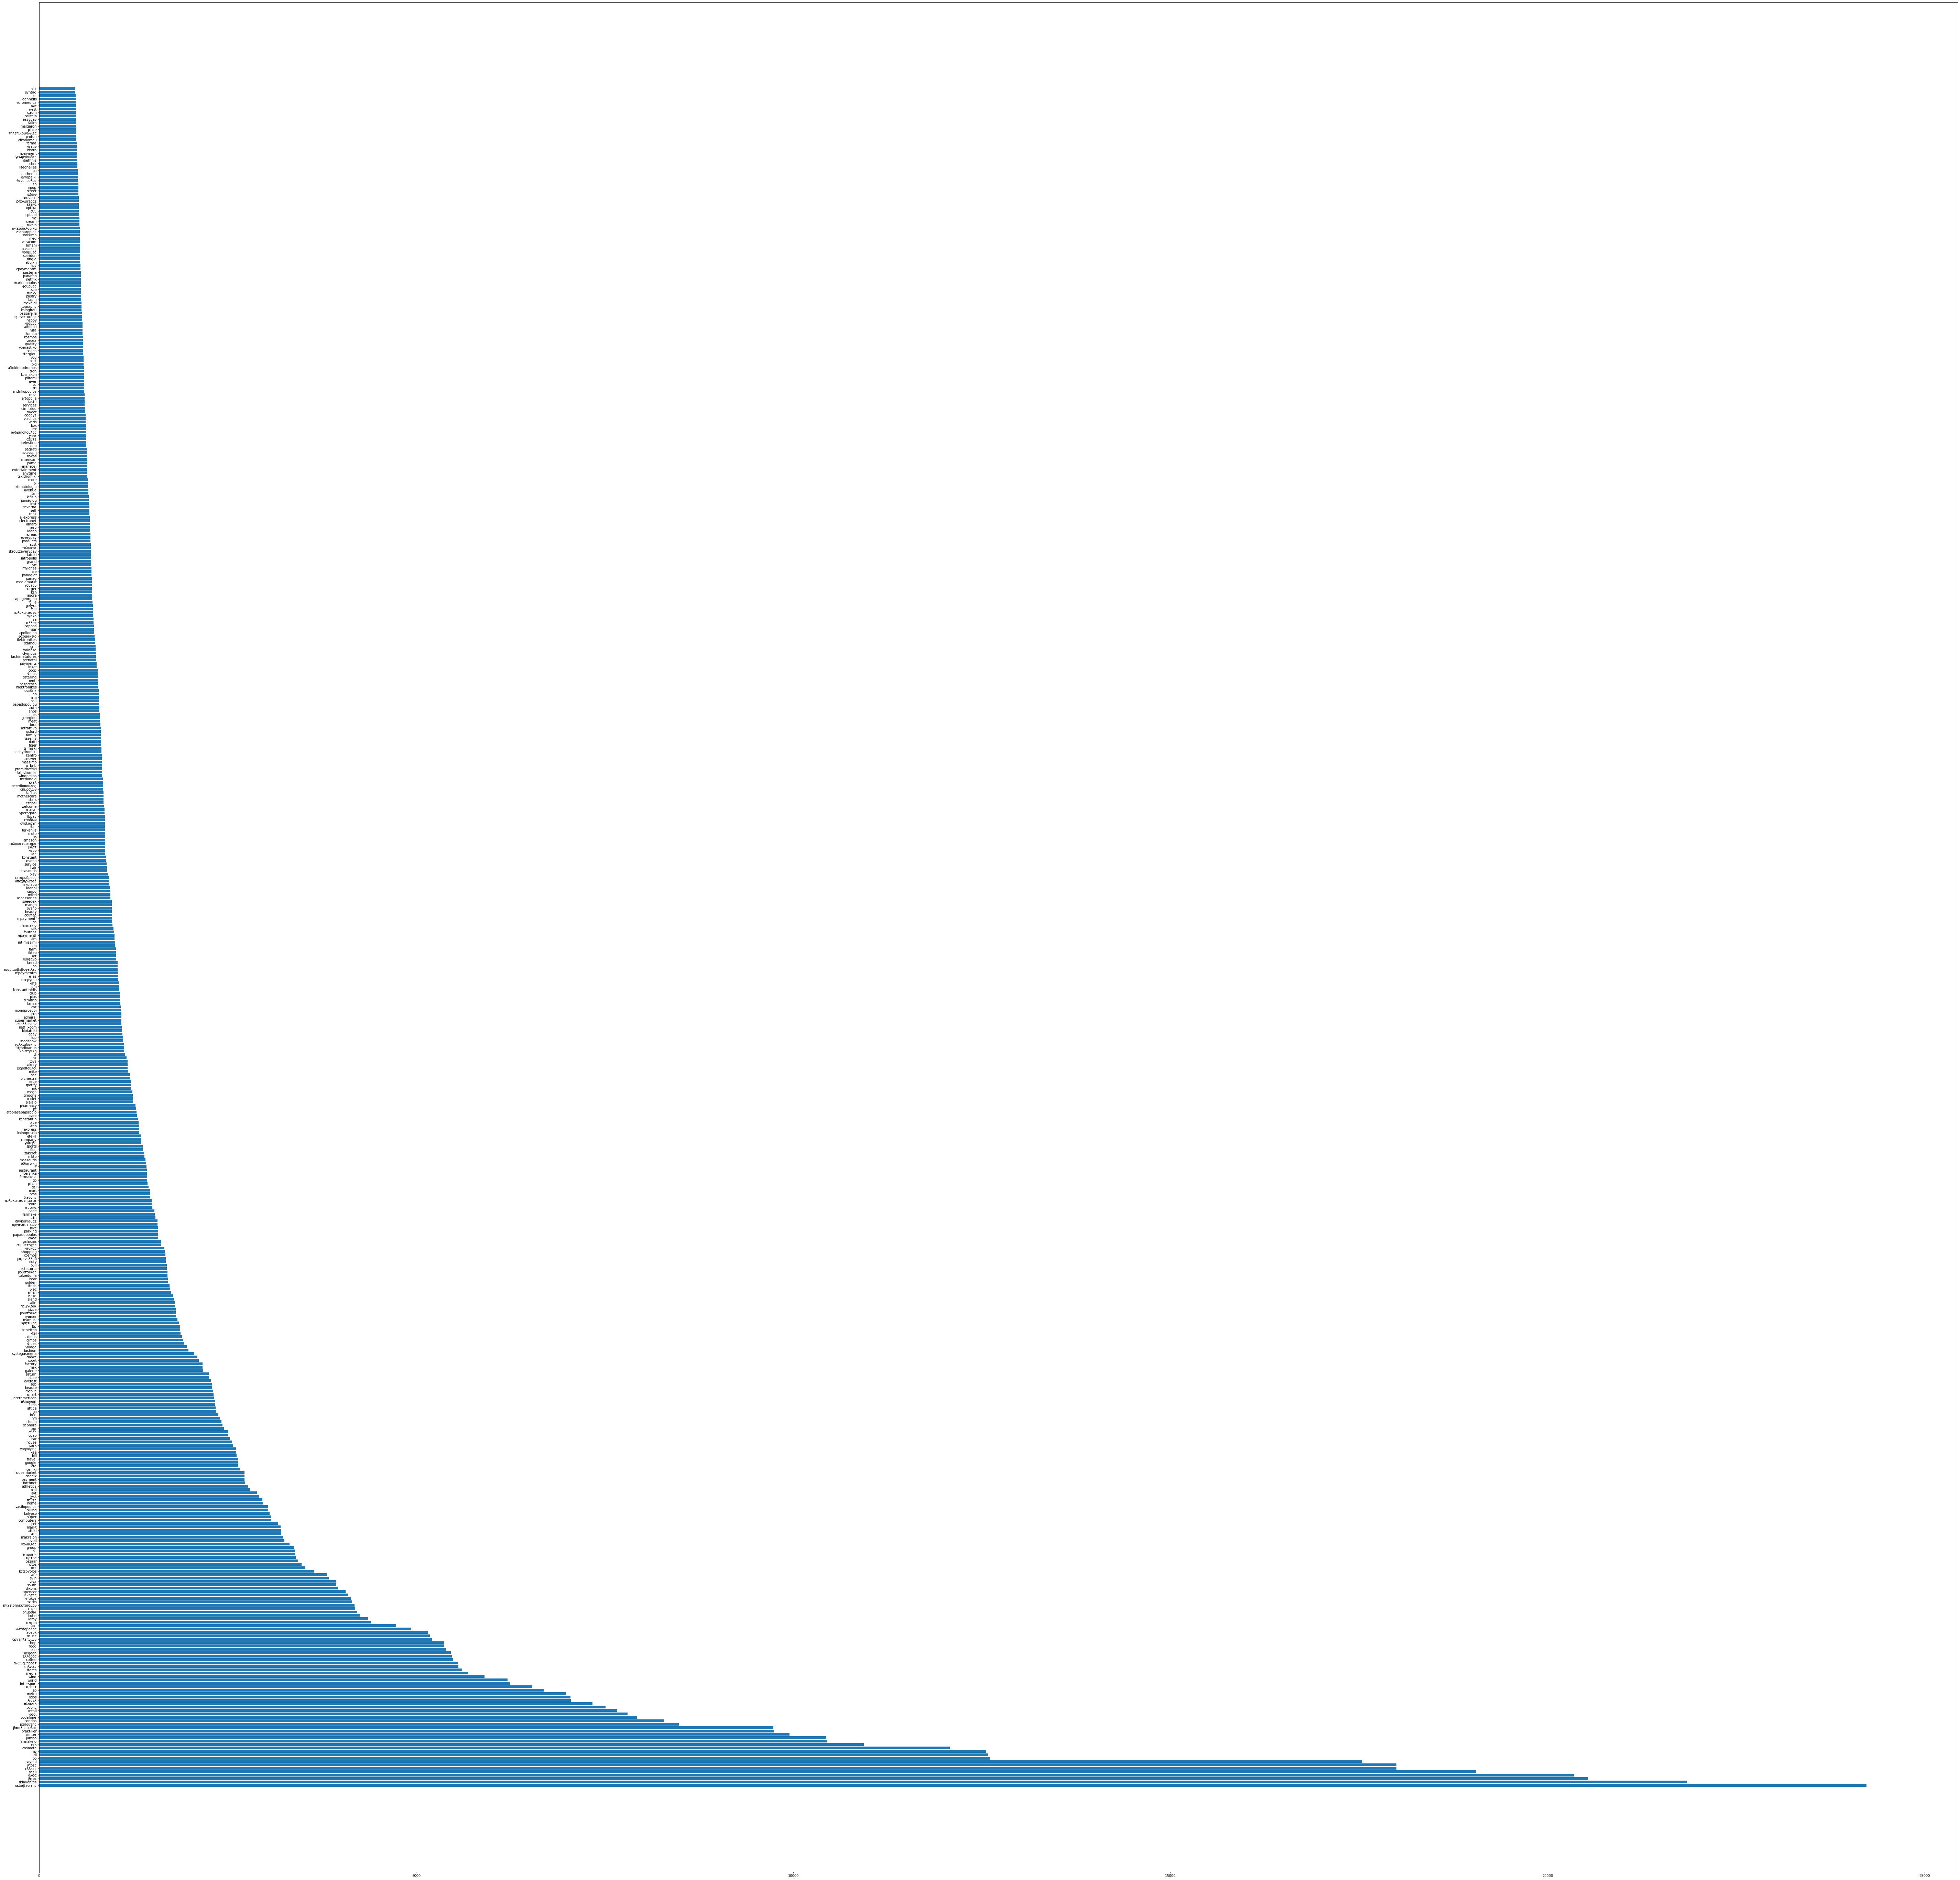

In [103]:
test_tokenizer_df = tokenizer_df.reset_index(drop=True)[0:500]

plt.figure(figsize=(100,100))
plt.barh(test_tokenizer_df.token, test_tokenizer_df.freq)
plt.show()

In [199]:
descriptions_as_padded_sequences = pad_description_sequences(description_tokenizer, cleaned_descriptions, description_classifier_model_params)

In [200]:
dummified_y_targets = dummify_y_targets(description_targets)

In [201]:
description_classifier_y_dummies = dummified_y_targets["y_dummies"]
description_classifier_y_labels = dummified_y_targets["y_labels"]

In [202]:
splited_training_test_set = split_training_test_set(descriptions_as_padded_sequences, description_classifier_y_dummies, description_classifier_model_params)

In [203]:
description_classifier_X_train = splited_training_test_set["X_train"]
description_classifier_y_train = splited_training_test_set["y_train"]
description_classifier_X_test = splited_training_test_set["X_test"]
description_classifier_y_test = splited_training_test_set["y_test"]

In [204]:
from typing import Dict, Union
from tensorflow import argmax
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

def train_description_classifier_model_test(
    X_train: Union[pd.Series, pd.DataFrame],
    y_train: Union[pd.Series, pd.DataFrame],
    y_labels: list,
    conf: Dict[str, int],
):
    """Train model on given inputs """
    model = Sequential()
    model.add(
        Embedding(conf["max_words"], conf["embedding_dimensions"], input_length=X_train.shape[1],)
    )
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(y_labels), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        X_train.to_numpy(),
        y_train.to_numpy(),
        validation_split=0.2,
        batch_size=conf["batch_size"],
        epochs=conf["epochs"],
    )

    return model

In [205]:
description_classifier_model = train_description_classifier_model_test(description_classifier_X_train, description_classifier_y_train, description_classifier_y_labels, description_classifier_model_params)

Epoch 1/5
8733/8733 [==============================] - 207s 23ms/step - loss: 1.2132 - accuracy: 0.6595 - val_loss: 0.8514 - val_accuracy: 0.7629
Epoch 2/5
8733/8733 [==============================] - 220s 25ms/step - loss: 0.8380 - accuracy: 0.7663 - val_loss: 0.8051 - val_accuracy: 0.7764
Epoch 3/5
8733/8733 [==============================] - 226s 26ms/step - loss: 0.7837 - accuracy: 0.7813 - val_loss: 0.7824 - val_accuracy: 0.7843
Epoch 4/5
8733/8733 [==============================] - 203s 23ms/step - loss: 0.7533 - accuracy: 0.7900 - val_loss: 0.7676 - val_accuracy: 0.7886
Epoch 5/5
8733/8733 [==============================] - 208s 24ms/step - loss: 0.7284 - accuracy: 0.7967 - val_loss: 0.7573 - val_accuracy: 0.7924


In [109]:
evaluated_model = evaluate_model(description_classifier_model, description_classifier_X_test, description_classifier_y_test)
description_classifier_model_accuracy = evaluated_model["accuracy"]
description_classifier_model_loss = evaluated_model["loss"]

10790/10790 [==============================] - 19s 2ms/step - loss: 0.7382 - accuracy: 0.8027


In [220]:
descriptions

0    KIZOGL SALMA
Name: description, dtype: object

In [175]:
train_transactions_df.loc[train_transactions_df["classification"]=="gambling"]

description classification
745221              KAPSH BAIO       gambling
745222              KAPSH BAIO       gambling
745223              KAPSH BAIO       gambling
745224              KAPSH BAIO       gambling
745225              KAPSH BAIO       gambling
...                        ...            ...
749100            IXTERPSETTEX       gambling
749101                   SQPAY       gambling
749102      VIVA SPORT ODD BET       gambling
749103                  SKRILL       gambling
749104  PANAGIOTOPOUL EFTHYMIA       gambling

[3878 rows x 2 columns]

In [302]:
data = [["OLYMPIA ΟDΟS SΑ"], ["CARD PURCHASE INTERWETTEN MALTA"], ["DEYAP"]]
testing_transactions = pd.DataFrame(data)
testing_transactions.columns = ["description"]

descriptions, description_targets = get_descriptions_and_targets_from_transactions(testing_transactions)
print(descriptions)
#descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
#    .map_partitions(lambda dframe: dframe.apply(lambda row: greek_stemming(row))).compute(scheduler='processes')

descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: greek_to_english(row))).compute(scheduler='processes')
print(descriptions)
descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: english_stemmer(row))).compute(scheduler='processes')
print(descriptions)

cleaned_descriptions = clean_transaction_descriptions(descriptions)
print(cleaned_descriptions)
descriptions_as_padded_sequences = pad_description_sequences(description_tokenizer, cleaned_descriptions, description_classifier_model_params)

a= predict_with_classifier(description_classifier_model, descriptions_as_padded_sequences, description_classifier_y_labels)
print(a)
print(a["predictions"].T)


0                    OLYMPIA ΟDΟS SΑ
1    CARD PURCHASE INTERWETTEN MALTA
2                              DEYAP
Name: description, dtype: object
0                    olympia odos sa
1    card purchase interwetten malta
2                              deyap
Name: description, dtype: object
0                    OLYMPIA ODO SA
1    CARD PURCHAS INTERWETTEN MALTA
2                             DEYAP
Name: description, dtype: object
0                    olympia odo sa
1    card purchas interwetten malta
2                             deyap
Name: description, dtype: object
{'predictions':              0             1             2             3             4   \
0  2.208431e-07  6.254059e-08  4.444196e-06  1.404778e-05  1.120566e-08   
1  1.622851e-03  1.602061e-03  2.303984e-02  3.896698e-02  5.248189e-03   
2  1.776200e-08  1.167869e-06  7.376114e-08  3.411757e-07  1.191854e-08   

             5             6             7             8         9   ...  \
0  7.072383e-06  5.358063e-07  5.5854

In [213]:
def predict_with_classifier(model: Sequential, X: Union[pd.Series, pd.DataFrame], y_labels: list, other_category_threshold: float = 0.50):
    """Do predictions on given dataset."""
    if len(X) != 0:
        predictions = model.predict(X)
        prediction_labels_se = pd.Series([y_labels[argmax(p)] for p in predictions])
        confidence_se = pd.Series([p[argmax(p)] for p in predictions])

        # Check if all predictions confidence are below threshold or there are some predictions above it
        # If there are all of them below threshold change class to other
        below_threshold_se = pd.Series()
        for p in predictions:
            below_threshold = pd.Series(all(i < other_category_threshold for i in p))
            below_threshold_se = below_threshold_se.append(below_threshold, ignore_index=True)
        
        for i, value in below_threshold_se.items():
            # if not already other
            if value & (prediction_labels_se.iloc[i] != "other"):
                prediction_labels_se.iloc[i] = "other"
                # The new conf score will be set as the default threshold 
                confidence_se.iloc[i] = other_category_threshold

        

        return dict(
            predictions=pd.DataFrame(predictions),
            prediction_labels=prediction_labels_se,
            confidence_scores=confidence_se,
        )
    else:
        return dict(predictions=0, prediction_labels=0, confidence_scores=0)

In [72]:
description_classifier_y_labels

['charity and donation',
 'child and school',
 'clothing',
 'eating out and take aways',
 'education',
 'fashion and beauty',
 'fees/charges/taxes',
 'fun and leisure',
 'gambling',
 'household items/supplies',
 'housing',
 'insurance and pension',
 'medical/healthcare',
 'office/electronics/software',
 'other',
 'other essential',
 'other lifestyle',
 'savings/investments',
 'telecommunications',
 'transport and fuel',
 'utilities']

In [215]:
testing_transactions = train_transactions_df.drop_duplicates(subset="description").reset_index(drop=True)

descriptions, description_targets = get_descriptions_and_targets_from_transactions(testing_transactions)

#descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
#    .map_partitions(lambda dframe: dframe.apply(lambda row: greek_stemming(row))).compute(scheduler='processes')

descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: greek_to_english(row))).compute(scheduler='processes')

descriptions = dd.from_pandas(descriptions, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda dframe: dframe.apply(lambda row: english_stemmer(row))).compute(scheduler='processes')

cleaned_descriptions = clean_transaction_descriptions(descriptions)
descriptions_as_padded_sequences = pad_description_sequences(description_tokenizer, cleaned_descriptions, description_classifier_model_params)

a= predict_with_classifier(description_classifier_model, descriptions_as_padded_sequences, description_classifier_y_labels)


<ipython-input-213-ea8e62ca1bfb>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  below_threshold_se = pd.Series()


### Check which are predicted wrong and with what confidence?

In [216]:
compare_df = pd.DataFrame()
compare_df["prediction_labels"] = a["prediction_labels"]
compare_df["confidence_scores"] = a["confidence_scores"]
compare_df["description"] = testing_transactions["description"]
compare_df["real_label"] = testing_transactions["classification"]
compare_df = compare_df[["description", "real_label", "prediction_labels", "confidence_scores"]]

In [217]:
different_df =compare_df.loc[compare_df["real_label"] != compare_df["prediction_labels"]]

In [218]:
different_df.to_csv(r'different_df.csv', index = False)

In [221]:
different_df.loc[(different_df["confidence_scores"]>0.5) & (different_df["prediction_labels"] !="other")]

description          real_label  \
2                      KARAGEORGI MAR  medical/healthcare   
38                 IATRIO MIKRON ZOON  medical/healthcare   
58                   STATHAT AIKATERI  medical/healthcare   
59                  TSILIVI STAMATAKI  medical/healthcare   
84      OIKONOM KERASINA SCENT  WOMAN  fashion and beauty   
...                               ...                 ...   
442355                        XARMANH               other   
444091                    XATZHNIKOLA               other   
445588                            XIO               other   
446160                         XONTOU               other   
447748                         PSARIA               other   

                prediction_labels  confidence_scores  
2                        clothing           0.782469  
38       household items/supplies           0.919187  
58                fun and leisure           0.561449  
59       household items/supplies           0.505125  
84                       clothing           0.525110  
...                           ...                ...  
442355         fashion and beauty           0.621529  
444091  eating out and take aways           0.616091  
445588                   clothing           0.531494  
446160         fashion and beauty           0.970029  
447748   household items/supplies           0.937792  

[18934 rows x 4 columns]

### Check through the pipeline

In [1]:
import pandas as pd

from kedro.runner import SequentialRunner
from kedro.io import DataCatalog, MemoryDataSet
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset
from kedro.extras.datasets.yaml import YAMLDataSet
from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

# Set up paths
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.wyre.composers.descriptions import create_train_card_description_classifier_pipeline

def data_catalog(transactions_df: pd.DataFrame, words_to_remove_df: pd.DataFrame, manual_adjust_df):
    return DataCatalog(
        { 
            "card_expenses_transactions": MemoryDataSet(transactions_df),
            "params:card_expenses_description_classifier_model_params": MemoryDataSet(dict(batch_size= 120, epochs= 5, test_size= 0.20, random_state= 20,  max_words= 9000, max_sequence_length=15, embedding_dimensions= 100)), 
            "card_expenses_words_to_remove": MemoryDataSet(words_to_remove_df),
            "card_expenses_description_classifier_model": TensorFlowModelDataset(
                "data/06_models/card_expenses_description_classifier_model",
            ),
            "duplicated_class_card_expenses": MemoryDataSet("data/01_raw/bank/duplicated_class_card_expenses.csv"),
            "card_expenses_duplicated_manual": MemoryDataSet(manual_adjust_df)
              }
    )
runner = SequentialRunner()

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
train_transactions_df = pd.read_csv('../data/01_raw/bank/card_expenses_transactions.csv')
words_to_remove_df = pd.read_csv("../data/01_raw/bag_of_words/expenses_cards_words_to_remove.csv")
manual_adjust_df = pd.read_csv("../data/01_raw/bank/duplicated_class_card_expenses_manual.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/01_raw/bag_of_words/expenses_cards_words_to_remove.csv'

In [3]:
train_transactions_df["is_income"]=False

In [4]:
train_transactions_df

description      classification  is_income
0              CHALVATZIS PANAGIO  medical/healthcare      False
1              CHALVATZIS PANAGIO  medical/healthcare      False
2        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False
3        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False
4        ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False
...                           ...                 ...        ...
1637460                     ΩΣΤΙΝ               other      False
1637461                        ΩΤ               other      False
1637462                      ΩΤΤΑ               other      False
1637463                     ΩΤΤΑΣ               other      False
1637464                     ΩΦΦΡΕ               other      False

[1637465 rows x 3 columns]

In [4]:
test = train_transactions_df.iloc[0:10000]

In [5]:
catalog = data_catalog(train_transactions_df, words_to_remove_df, manual_adjust_df)
# Create pipeline
pipeline = create_train_card_description_classifier_pipeline()
# Run pipeline
input_posts_dict = runner.run(pipeline, catalog)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Epoch 1/5
8733/8733 [==============================] - 226s 26ms/step - loss: 1.2163 - accuracy: 0.6586 - val_loss: 0.8651 - val_accuracy: 0.7575
Epoch 2/5
8733/8733 [==============================] - 227s 26ms/step - loss: 0.8386 - accuracy: 0.7653 - val_loss: 0.8108 - val_accuracy: 0.7739
Epoch 3/5
8733/8733 [==============================] - 226s 26ms/step - loss: 0.7810 - accuracy: 0.7814 - val_loss: 0.7891 - val_accuracy: 0.7813
Epoch 4/5
8733/8733 [==============================] - 222s 25ms/step - loss: 0.7515 - accuracy: 0.7901 - val_loss: 0.7754 - val_accuracy: 0.7865
Epoch 5/5
8733/8733 [========

In [6]:
def split_transactions_on_duplicated(transactions_df):
    """ Get duplicated and not duplicated transactions based on same descriptions but differenrent mcc or mcg names"""
    # Keep unique values based on both description and  other column
    unique_transactions_df = transactions_df.drop_duplicates().reset_index(drop=True)
    # Get from the entire unique (both description and other included columns)
    # the positions of duplicated based on description
    duplicated_descriptions_positions = unique_transactions_df.duplicated(
        keep=False, subset="description"
    )
    # So these will contain the same descriptions that have differnet categories
    # Keep the non duplicated
    non_duplicated = unique_transactions_df[~duplicated_descriptions_positions]
    non_duplicated = non_duplicated.reset_index(drop=True)
    # Keep the duplicated
    duplicated = unique_transactions_df[duplicated_descriptions_positions]
    duplicated = duplicated.reset_index(drop=True)

    return duplicated, non_duplicated

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
input_posts_dict

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'card_expenses_description_predictions':              0         1
 0     0.467320  0.532680
 1     0.467320  0.532680
 2     0.468437  0.531563
 3     0.468437  0.531563
 4     0.468437  0.531563
 ...        ...       ...
 9991  0.464498  0.535502
 9992  0.468998  0.531002
 9993  0.462270  0.537730
 9994  0.460840  0.539160
 9995  0.464976  0.535024
 
 [9996 rows x 2 columns],
 'description_classifier_model_loss': 0.014000000432133675,
 'card_expenses_output_transactions':                     description    classification_x  is_income  \
 0            CHALVATZIS PANAGIO  medical/healthcare      False   
 1            CHALVATZIS PANAGIO  medical/healthcare      False   
 2      ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False   
 3      ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False   
 4      ΠΑΡΑΣΧΗΣ ΣΠΥΡΙΔΩΝ MY VET  medical/healthcare      False   
 ...                         ...                 ...        ...   
 10023       SALAGIANNIS STAVROS  fashion and beauty 

In [2]:
import pandas as pd
import pickle

from kedro.runner import SequentialRunner
from kedro.io import DataCatalog, MemoryDataSet
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset
from kedro.extras.datasets.yaml import YAMLDataSet
from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

# Set up paths
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.wyre.composers.descriptions import create_classify_card_descriptions_pipeline

def data_catalog(transactions_df: pd.DataFrame, words_to_remove_df: pd.DataFrame, manual_adjust_df):
    return DataCatalog(
        { 
            "card_expenses_transactions": MemoryDataSet(transactions_df),
            "params:card_expenses_description_classifier_model_params": MemoryDataSet(dict(batch_size= 120, epochs= 5, test_size= 0.20, random_state= 20,  max_words= 9000, max_sequence_length=15, embedding_dimensions= 100)), 
            "card_expenses_words_to_remove": MemoryDataSet(words_to_remove_df),
            "card_expenses_description_classifier_model": TensorFlowModelDataset(
                "../data/06_models/card_expenses_description_classifier_model",
            ),
            "duplicated_class_card_expenses": MemoryDataSet("data/01_raw/bank/duplicated_class_card_expenses.csv"),
            "card_expenses_duplicated_manual": MemoryDataSet(manual_adjust_df),
            "params:is_training": MemoryDataSet(False),
            "card_expenses_description_tokenizer": PickleDataSet("../data/06_models/card_expenses_description_tokenizer/card_expenses_description_tokenizer.pickle"),
            "card_expenses_description_classifier_y_labels": YAMLDataSet("../data/06_models/labels/card_expenses_description_classifier_y_labels.yaml"),
              }
    )
runner = SequentialRunner()

train_transactions_df = pd.read_csv('../data/01_raw/bank/card_expenses_transactions.csv')
words_to_remove_df = pd.read_csv("../data/01_raw/bag_of_words/card_expenses_words_to_remove.csv")
manual_adjust_df = pd.read_csv("../data/01_raw/bank/duplicated_class_card_expenses_manual.csv")

In [3]:
test = train_transactions_df.sample(frac=1)
test = test[0:2000].reset_index(drop=True)
test

description             classification
0         KARAKOSTA SIA EE         medical/healthcare
1            PAYPAL KLM SA                   clothing
2             SUSSEX AC UK                  education
3             NO COFFEE AE   household items/supplies
4     DEBENHAMS RETAIL PLC   household items/supplies
...                    ...                        ...
1995           ΚΟΤΖΟΧΑΜΠΟΣ                      other
1996         ISB HELLAS SA                   clothing
1997            KLIRONOMOS        savings/investments
1998   ENGLISH HOME GREECE   household items/supplies
1999      YAKINIKU BARBIES  eating out and take aways

[2000 rows x 2 columns]

In [5]:
catalog = data_catalog(test_random_bank_data, words_to_remove_df, manual_adjust_df)
import time
start_time = time.time()
# Create pipeline
pipeline = create_classify_card_descriptions_pipeline()
# Run pipeline
input_posts_dict = runner.run(pipeline, catalog)
print("--- %s seconds ---" % (time.time() - start_time))


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/fsspec/implementations/local.py:29: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  warnings.warn(
--- 25.549622058868408 seconds ---


#### Extra test with some alpha bank data

In [ ]:
test_random_bank_data = pd.read_csv('../data/01_raw/bank/testing_processed_bank_data/test_bank.csv')
test_random_bank_data = test_random_bank_data.loc[test_random_bank_data["iban"]=="4017790000293109"].reset_index(drop=True)
test_random_bank_data = test_random_bank_data.drop_duplicates(subset = "description").reset_index(drop=True)
test_random_bank_data = test_random_bank_data[["description"]]

test_random_bank_data.columns = ["processed_description"]
test_random_bank_data["initial_description"] = test_random_bank_data["processed_description"]
test_random_bank_data["classification"] = "None"

In [7]:
b = input_posts_dict["card_expenses_output_transactions"]
b["old_classification"] = input_posts_dict["description_targets"]
b

#### Cleaning functions for check

In [12]:
import dask.dataframe as dd
import multiprocessing
import pandas as pd
import numpy as np
import datetime
import string
import re
import unicodedata
from greeklish.converter import Converter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from romanize import romanize
import datetime
import re
import unicodedata
from typing import Any, Dict, Union

from numba import jit

def remove_accent_and_lowercase(description: str) -> str:
    normalized_description = unicodedata.normalize("NFD", description)
    cleaned_description = re.sub("[\u0300-\u036f]", "", normalized_description).lower()

    return cleaned_description

def clean_transaction_descriptions(descriptions_se: pd.Series) -> Union[pd.Series, pd.DataFrame]:
    cleaned_descriptions_se = descriptions_se.apply(lambda row: remove_accent_and_lowercase(row))
    cleaned_descriptions_se = cleaned_descriptions_se.apply(lambda row: convert_characters(row))

    return cleaned_descriptions_se

def remove_numbers(text):
    """ Example: "FYSIKO AERIO VW507" is converted to "FYSIKO AERIO VW" """
    pattern = r"[0-9]"
    # Match all digits in the string and replace them by empty string
    modified_text = re.sub(pattern, "", text)

    return modified_text

def remove_single_letters(text):
    """ Removes the single letters included in descriptions """
    no_letter = [word for word in text.split() if len(word) > 1]
    words_no_letter = " ".join(no_letter)

    return words_no_letter

def connect_single_letters(text):
    """ Example: "D E Y A  SITEIAS" is converted to "DEYA  SITEIAS" """
    pattern = re.compile(r"\b([a-z]) (?=[a-z]\b)", re.I)

    return re.sub(pattern, r"\g<1>", text)

def clean_website_name(text: str):
    """ Example: "www.eshop.gr" is converted to "eshop" """
    list_of_words = []
    if text is not np.nan:
        for word in text.split():
            word = word.replace("www.", "")
            word = word.replace("WWW.", "")
            word = word.replace("WWW", "")
            word = word.replace("www", "")
            word = word.replace(".gr", "")
            word = word.replace(".GR", "")
            word = word.replace(".com", "")
            word = word.replace(".COM", "")
            list_of_words.append(word)
        words = " ".join(list_of_words)
    else:
        words = ""

    return words

def remove_punctuation(text):
    """ Removes punctations from descriptions """
    word_list = []
    for words in text:
        characters_list = []
        for characters in words:
            if characters not in string.punctuation:
                characters_list.append(characters)
            else:
                characters_list.append(" ")
        word = "".join(characters_list)
        word_list.append(word)
    words = "".join(word_list)

    return words


def clean_description(description):
    """ Does the basic cleaning in a description"""
    cleaned_description = clean_website_name(description)
    cleaned_description = remove_punctuation(cleaned_description)
    cleaned_description = connect_single_letters(cleaned_description)
    cleaned_description = remove_numbers(cleaned_description)
    cleaned_description = remove_single_letters(cleaned_description)

    return cleaned_description

def convert_characters(description: str) -> str:
    """Converts the mixed letters of greek and english of a word to only english"""
    greek = False
    english = False
    new_description = ""
    for word in description.split():
        # TO DO: if it finds greek and english character has not to look other times
        for letter in word:

            if is_english(letter):
                english = True
            else:
                greek = True

        if (english == True) & (greek == True):
            greek_alphabet = "ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω"
            new_alphabet = "AaBbGgDdEeZzHhJjIiKkLlMmVvXxOoPpPpSssTtYyFfXxYyWw"
            greek_to_new = str.maketrans(greek_alphabet, new_alphabet)

            new_description = new_description + " " + word.translate(greek_to_new)
        else:
            new_description = new_description + " " + word

        greek = False
        english = False

    return new_description[1:]

def is_english(character):
    """Checks if a character is english"""
    try:
        character.encode(encoding="utf-8").decode("ascii")
    except UnicodeDecodeError:
        return False
    else:
        return True

import time

def clean_descriptions(transactions_df):
    """ 
    Combines all the basic cleaning functions. Also used the old one cleaning 
    function used for incoming transactions.

    Clean description function includes: clean_website_name, remove_punctuation, 
    connect_single_letters, remove_numbers, remove_single_letters

    Clean transaction descriptions includes: remove_accent_and_lowercase, 
    convert_characters
    """
    start_time = time.time()
    transactions_df["processed_description"] = transactions_df["processed_description"].apply(str)
    # Use the unique ones and then merge it in order to run quickly
    unique_descriptions_df = transactions_df.processed_description.drop_duplicates().reset_index(
        drop=True
    )
    processed_unique_descriptions_df = unique_descriptions_df.copy()
    processed_unique_descriptions_df = pd.DataFrame(processed_unique_descriptions_df)
    # Try to create one time a dask object and pass all the functions one by one
    processed_unique_descriptions_df["new_description"] = (
        dd.from_pandas(
            processed_unique_descriptions_df["processed_description"],
            npartitions=4 * multiprocessing.cpu_count(),
        )
        .map_partitions(lambda dframe: dframe.apply(lambda row: clean_description(row)))
        .compute(scheduler="processes")
    )
    # Call the old function, as used also in incoming transactions
    cleaned_unique_descriptions_se = clean_transaction_descriptions(
        processed_unique_descriptions_df["new_description"]
    )
    # Replace the old column values with the new
    processed_unique_descriptions_df["new_description"] = cleaned_unique_descriptions_se

    cleaned_descriptions_df = pd.merge(
        transactions_df,
        processed_unique_descriptions_df,
        on=["processed_description", "processed_description"],
    )

    cleaned_descriptions_df = cleaned_descriptions_df[
        ["initial_description", "classification", "new_description"]
    ]
    cleaned_descriptions_df.columns = [
        "initial_description",
        "classification",
        "processed_description",
    ]
    print("--- %s seconds ---" % (time.time() - start_time))
    return cleaned_descriptions_df

In [23]:
clean_descriptions(test_random_bank_data)[100:150]


--- 1.6292369365692139 seconds ---


initial_description classification    processed_description
100                     AEGEAN           None                   aegean
101            AFOI LOTSARI OE           None          afoi lotsari oe
102            ELECTRONIC PLUS           None          electronic plus
103    EΣTIATOPIA NOΣTIMA ΨHTA           None  estiatopia nostima yhta
104          AEGEAN KOLOKITHAS           None        aegean kolokithas
105                       LIDL           None                     lidl
106     MIXALAKOS X KAI SIA EE           None     mixalakos kai sia ee
107                  PRAKTIKER           None                praktiker
108              COFFEE ISLAND           None            coffee island
109        ANASTASIOS CHOUNTAS           None      anastasios chountas
110       YIOI KON SCHIZA O.E.           None       yioi kon schiza oe
111  A SPILIOTIS N SKAPERDAS I           None      spiliotis skaperdas
112                 MR CARWASH           None               mr carwash
113               CoΦΦeeIΣΛaΞΔ           None             coffeeislaxd
114             STASI SOUVLAKI           None           stasi souvlaki
115             AEGEAN STAIKOS           None           aegean staikos
116     MASOUTIS AMIKLON 1 610           None         masoutis amiklon
117               TOBACCO HOME           None             tobacco home
118  MASOUTIS AETORACHIS 50 64           None      masoutis aetorachis
119       PALIAROUTAS THEODORO           None     paliaroutas theodoro
120                   PROSTAGE           None                 prostage